# Newsvendor Problem
## Note: Size-Limited by the IBM CPLEX community edition solver

In [35]:
from docplex.mp.model import Model
import random
random.seed(a=100)
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import gridspec
from matplotlib.ticker import PercentFormatter
nbins = 30

In [65]:
# Prints the histogram of the random variable and the empirical accumulated probability
def doubleHist(data, xlabel=None):
    plt.figure(figsize=(15,6),dpi=300)
    gs  = gridspec.GridSpec(1, 2, width_ratios=[4, 1], wspace=0.6)
    ax  = plt.subplot(gs[0])
    ax3 = plt.subplot(gs[1])
    ax.grid(True)
    ax.set_title(xlabel)
    ax.set_ylabel('Likelihood of occurrence',color='blue')
    ax2 = ax.twinx()
    ax2.set_ylabel('Cumulative probability',color='red')
    # plot the density and cumulative histogram
    n, bins, patches = ax.hist(data, nbins, density=True, alpha=0.65, cumulative=False, label='Density', color='blue')
    n, bins, patches = ax2.hist(data, nbins, density=True, histtype='step', cumulative=True, label='CDF', color='red')
    ax3.boxplot(data,whis=[5,95])
    # tidy up the figure
    plt.show()

# Newsvendor Model with a Normal Distribution
### General Model, Maximizing the Expected Value

In [199]:
# Parameters of the model
# cost: is the procurement cost of each unit
# retail: selling price
# recover: scrap price 
# order: just an example of what would happen if we bought this number of items
cost    = 2
retail  = 15
recover = -3
ordr   = 600

# By sampling, we approximate integrals....
# The larger the sample, the more accurate.... but the harder the problem
samples = 100

# we have a (positive truncated) normal distribution for demand (can't have a negative demand... unless short selling....)
sigma   = 100
mu      = 400
demand  = [max(random.normalvariate(mu,sigma),0) for i in range(samples)]

# Compute from above economic parameters and defined order quantity.... note that this is also a random variable!
losses  = [-retail * min(ordr,demand[i]) + cost * ordr - recover * max(0,ordr-demand[i]) for i in range(samples)]
sol1    = losses.copy()

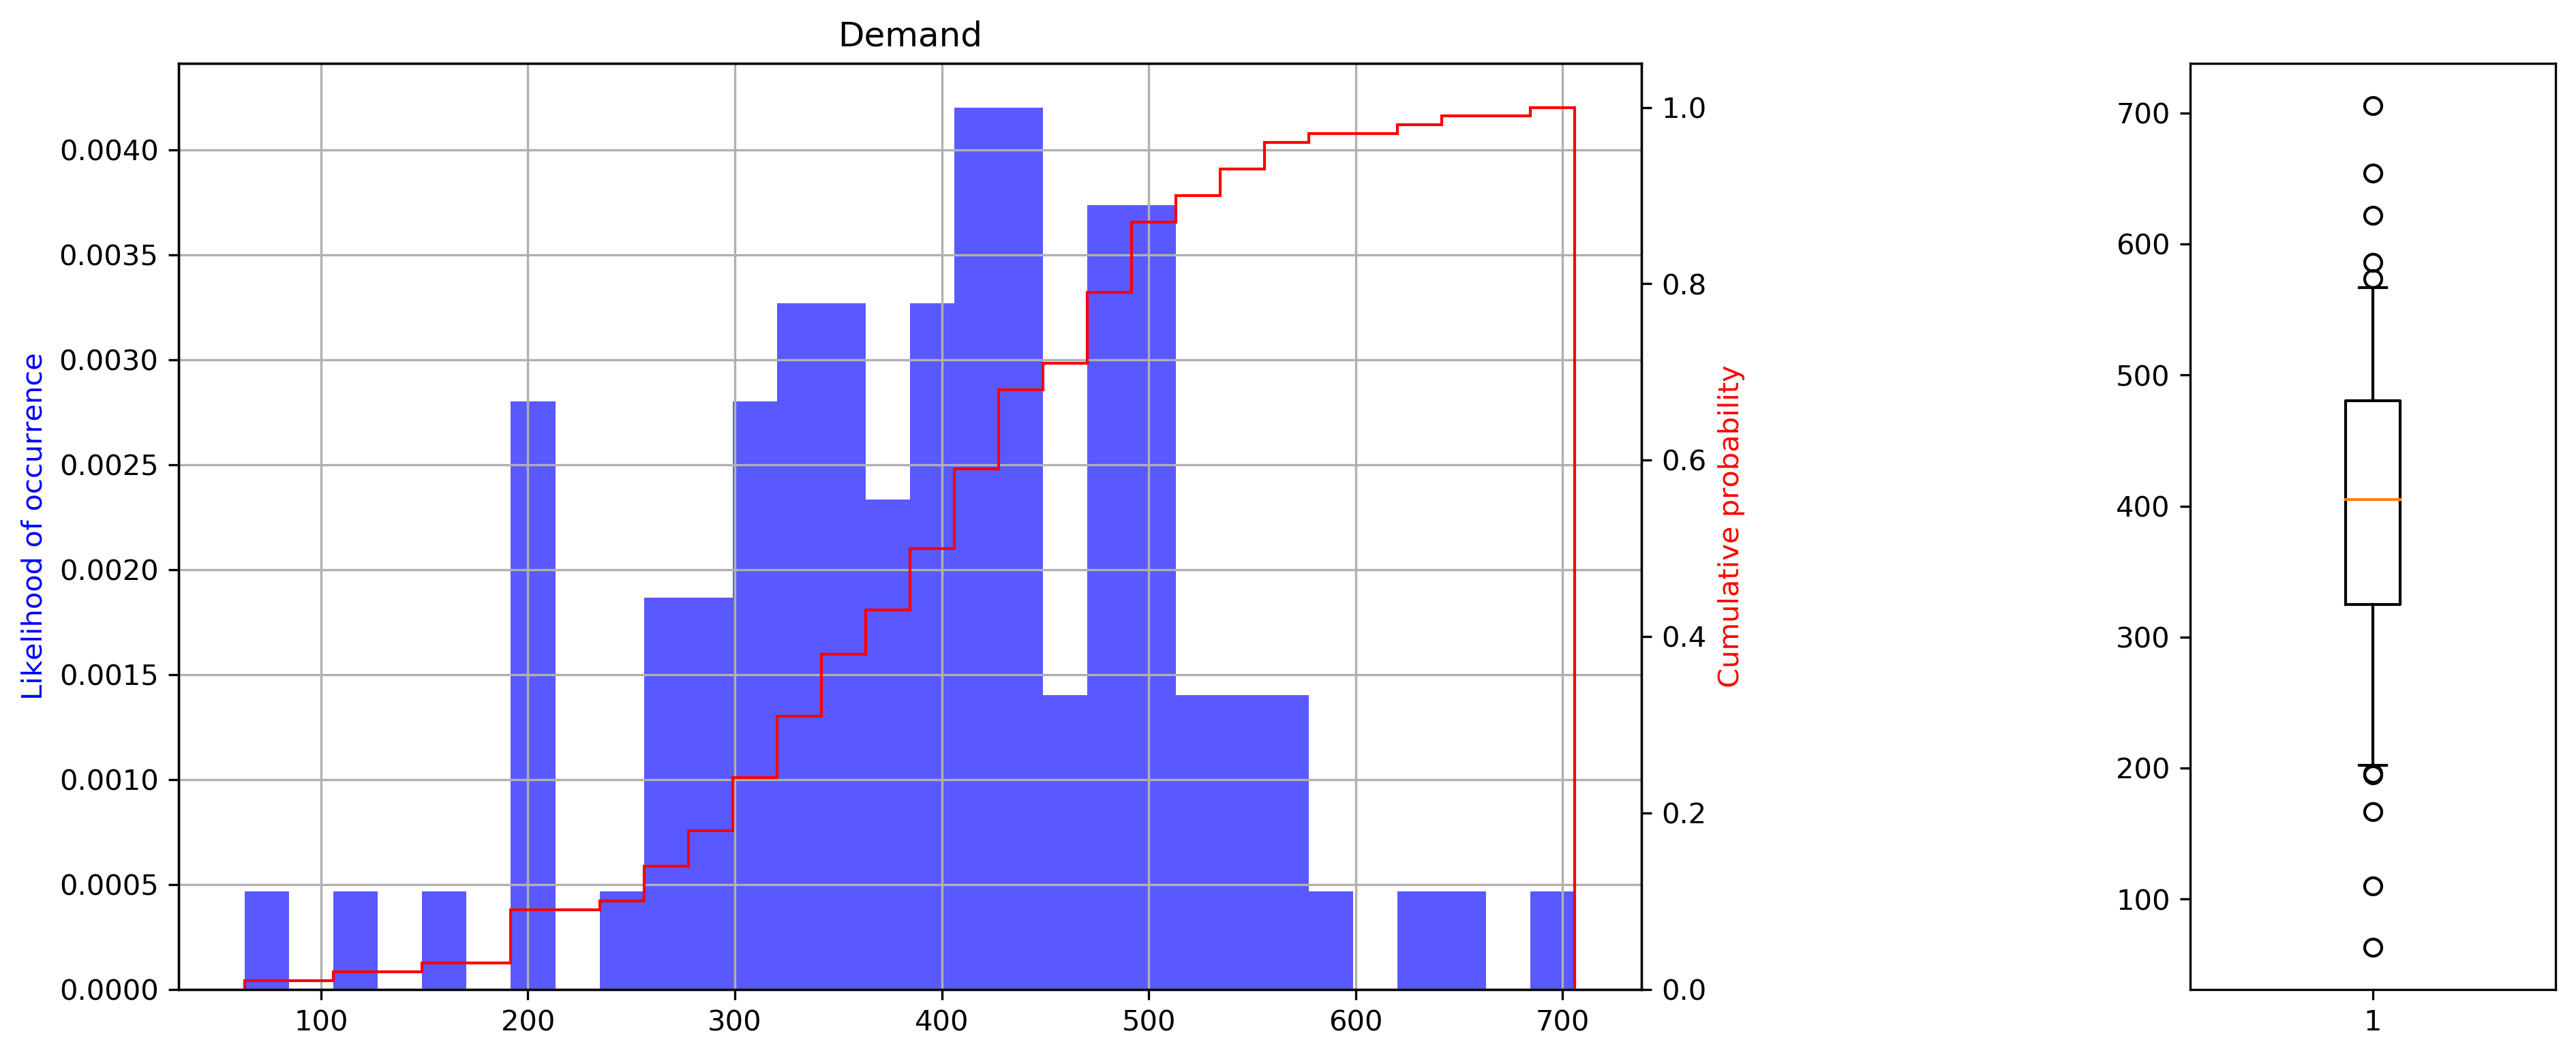

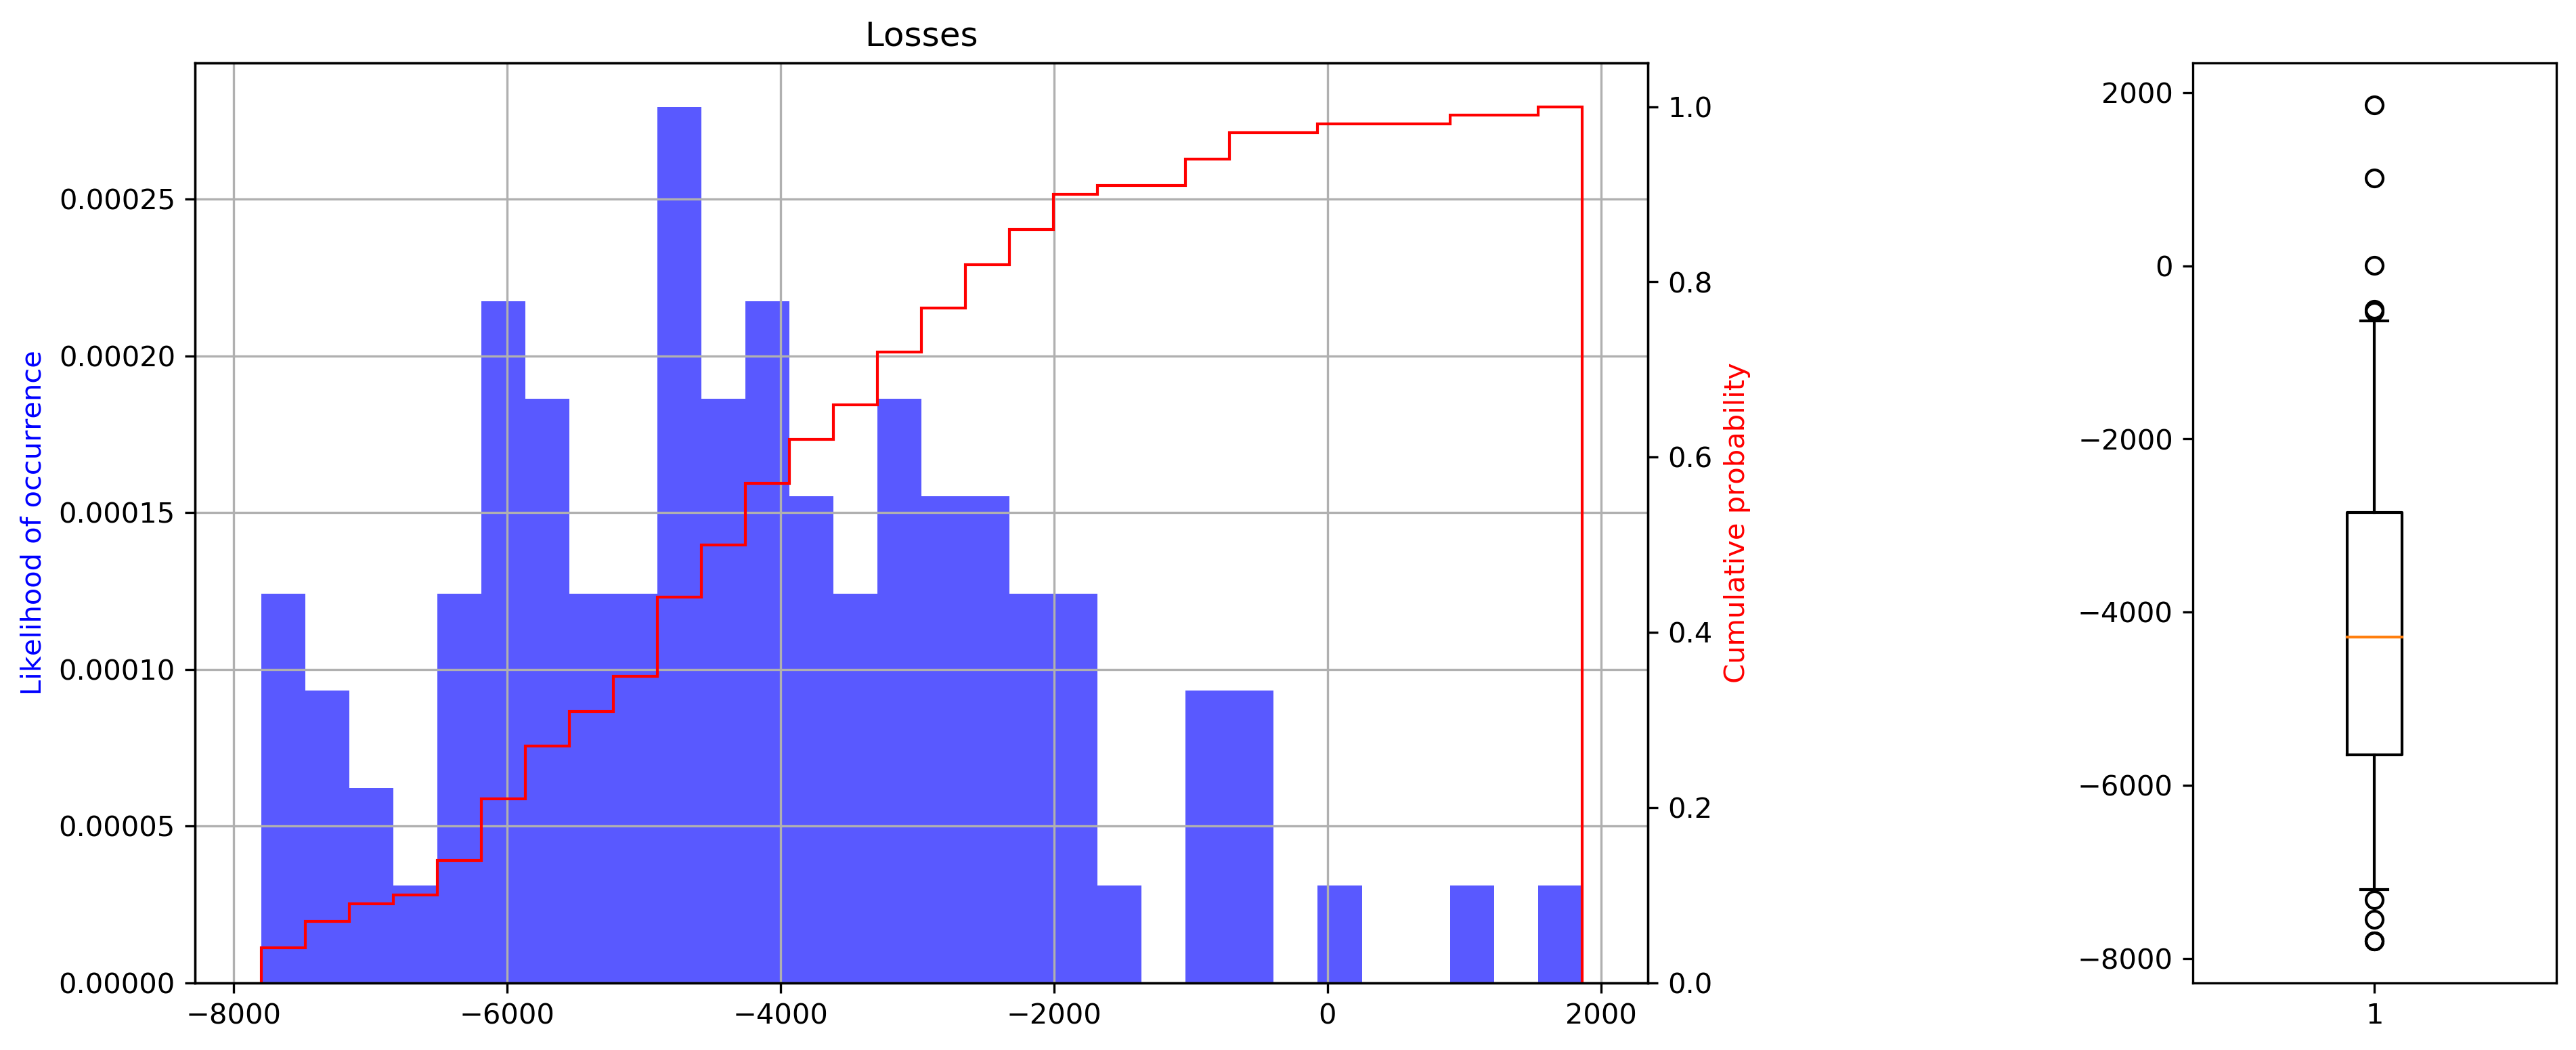

In [200]:
doubleHist(data=demand,xlabel='Demand')
doubleHist(data=losses,xlabel='Losses')

In [201]:
# Max and Min Revenue
rev_max  = max(demand)*(retail-cost)
rev_min  = max(demand)*(recover-cost)+min(demand)*retail
#print(rev_max, rev_min)

In [202]:
m = Model(name='newsVendor')


# Amount to Order
order = m.integer_var(name = 'order')

# Profit
profit = m.integer_var_list(samples,name = 'profit', lb=rev_min, ub = rev_max)

# Sales
sales = m.integer_var_list(samples, name = 'sales', ub = demand)

# Disoucounted Sales
discount = m.integer_var_list(samples, name = 'discount')

# Constraints
for i in range(samples):
    m.add_constraint(sales[i] + discount[i] == order)
    m.add_constraint(profit[i] == sales[i] * retail + discount[i] * recover - order * cost)

    
    
m.maximize(sum(profit[i] for i in range(samples))/samples)

In [203]:
solution = m.solve()

In [204]:
m.print_information()

Model: newsVendor
 - number of variables: 301
   - binary=0, integer=301, continuous=0
 - number of constraints: 200
   - linear=200
 - parameters: defaults
 - problem type is: MILP


In [205]:
# Objective Value
print(solution.get_objective_value())

4481.34


In [206]:
# Getting the value of the losses
sol2 = [-1 * i for i in (solution.get_values(profit))]

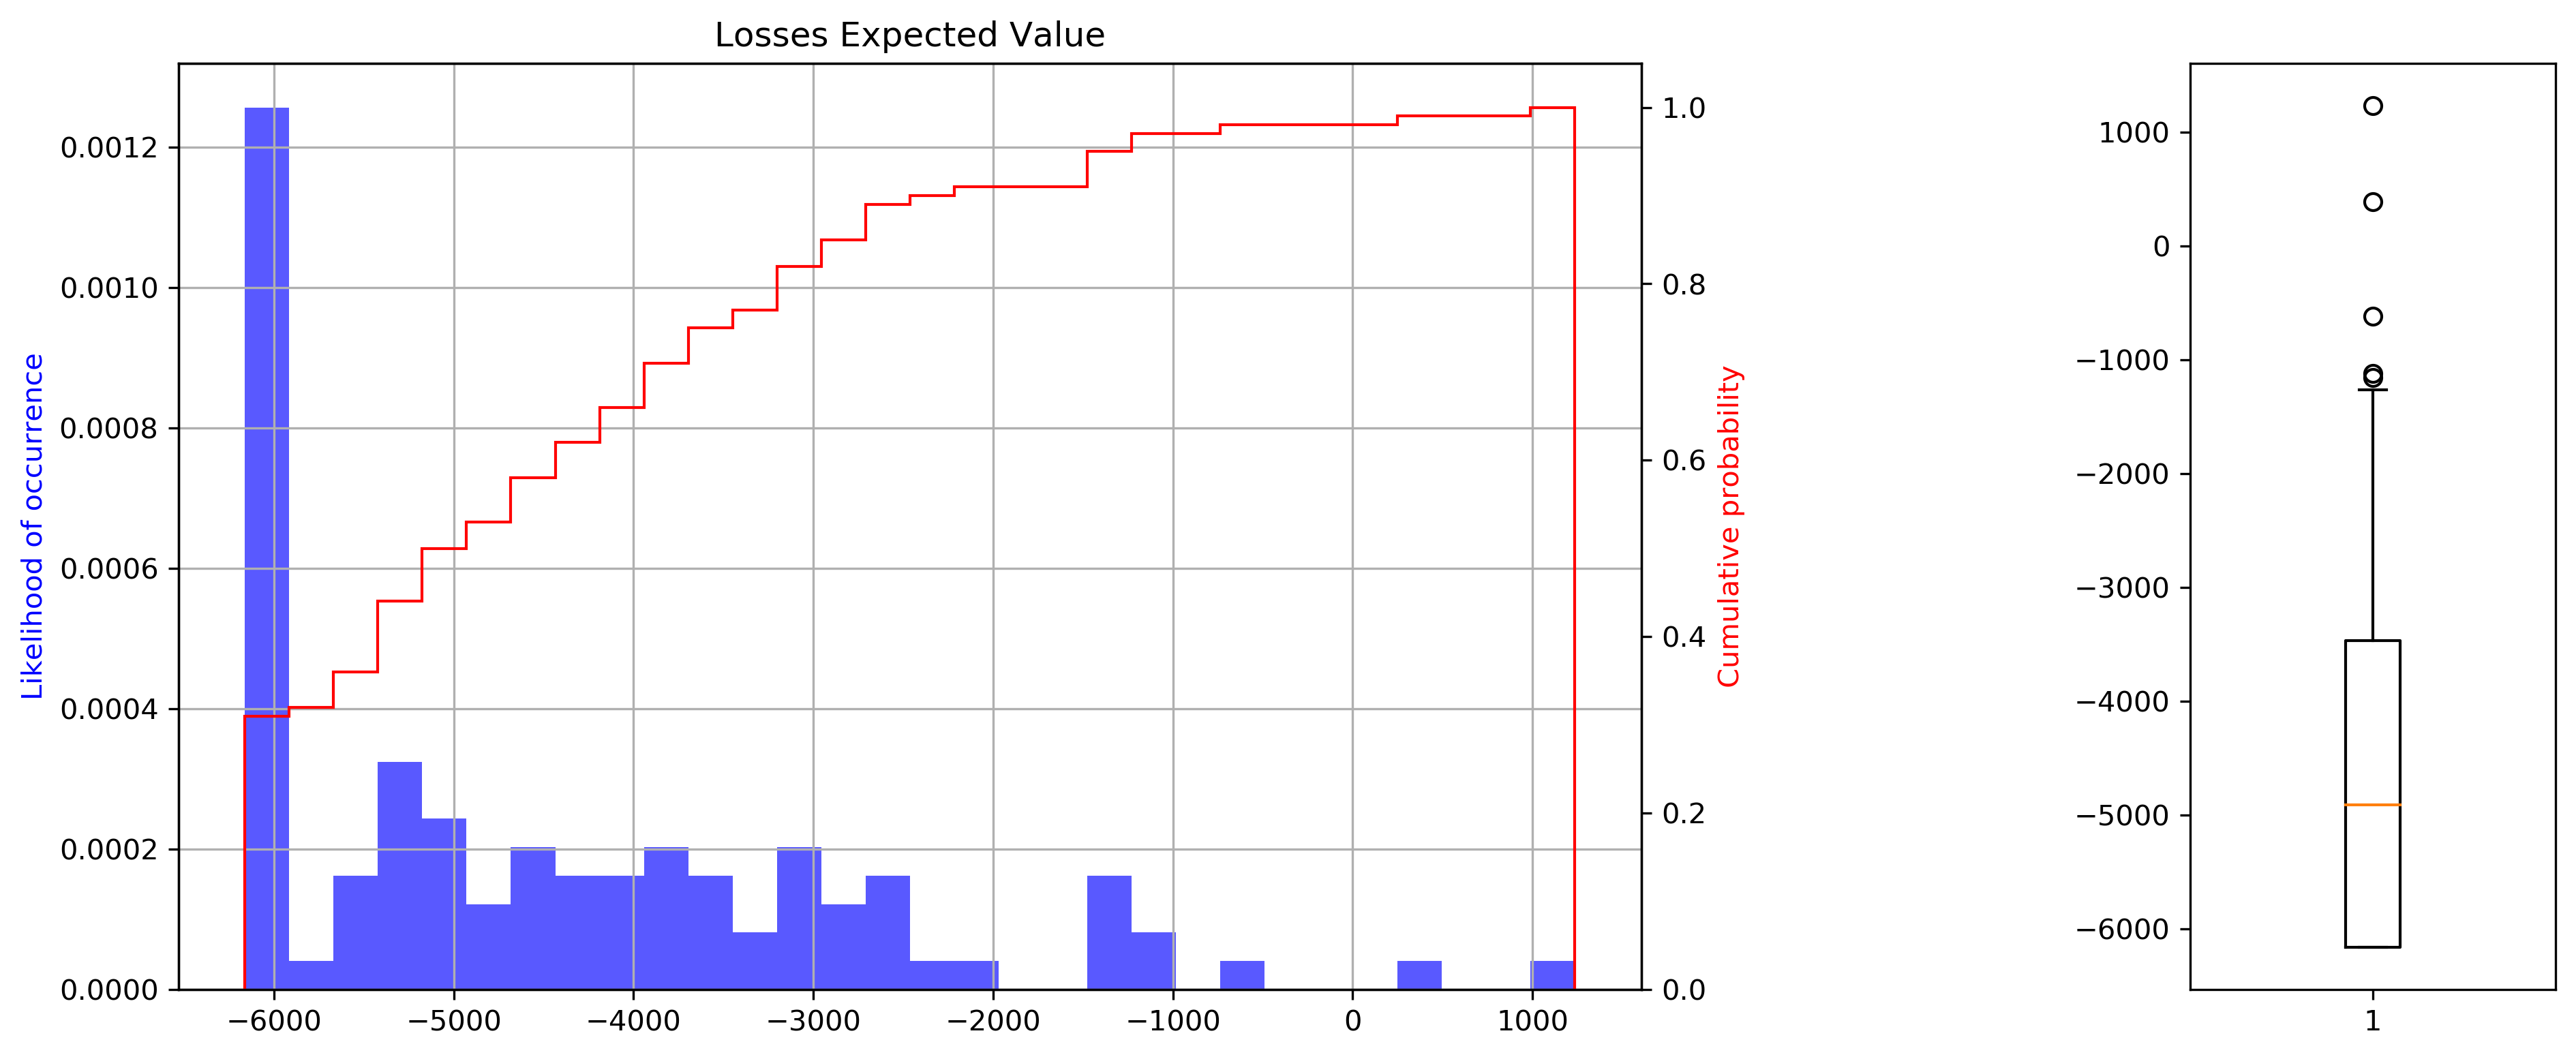

In [207]:
doubleHist(sol2, xlabel='Losses Expected Value')

# Newsvendor Model with a Normal Distribution
### Maximizing the worst case scenario

In [300]:
m1 = Model(name='newsVendorMaxWorstCase')


# Amount to Order
order = m1.integer_var(name = 'order')

# Profit
profit = m1.integer_var_list(samples,name = 'profit', lb=rev_min, ub = rev_max)

# Sales
sales = m1.integer_var_list(samples, name = 'sales', ub = demand)

# Disoucounted Sales
discount = m1.integer_var_list(samples, name = 'discount')

# Worst Case

worst = m1.integer_var(lb=rev_min, ub = rev_max, name = 'worst')

# Constraints
for i in range(samples):
    m1.add_constraint(sales[i] + discount[i] == order)
    m1.add_constraint(profit[i] == sales[i] * retail + discount[i] * recover - order * cost)
    m1.add_constraint(worst <= profit[i])

    
    
m1.maximize(worst)#sum(profit[i] for i in range(samples))/samples)

In [301]:
solution2 = m1.solve()

In [302]:
# Objective Value
print(solution2.get_objective_value())

819


In [303]:
# Getting the value of the losses
sol3 = [-1 * i for i in (solution2.get_values(profit))]

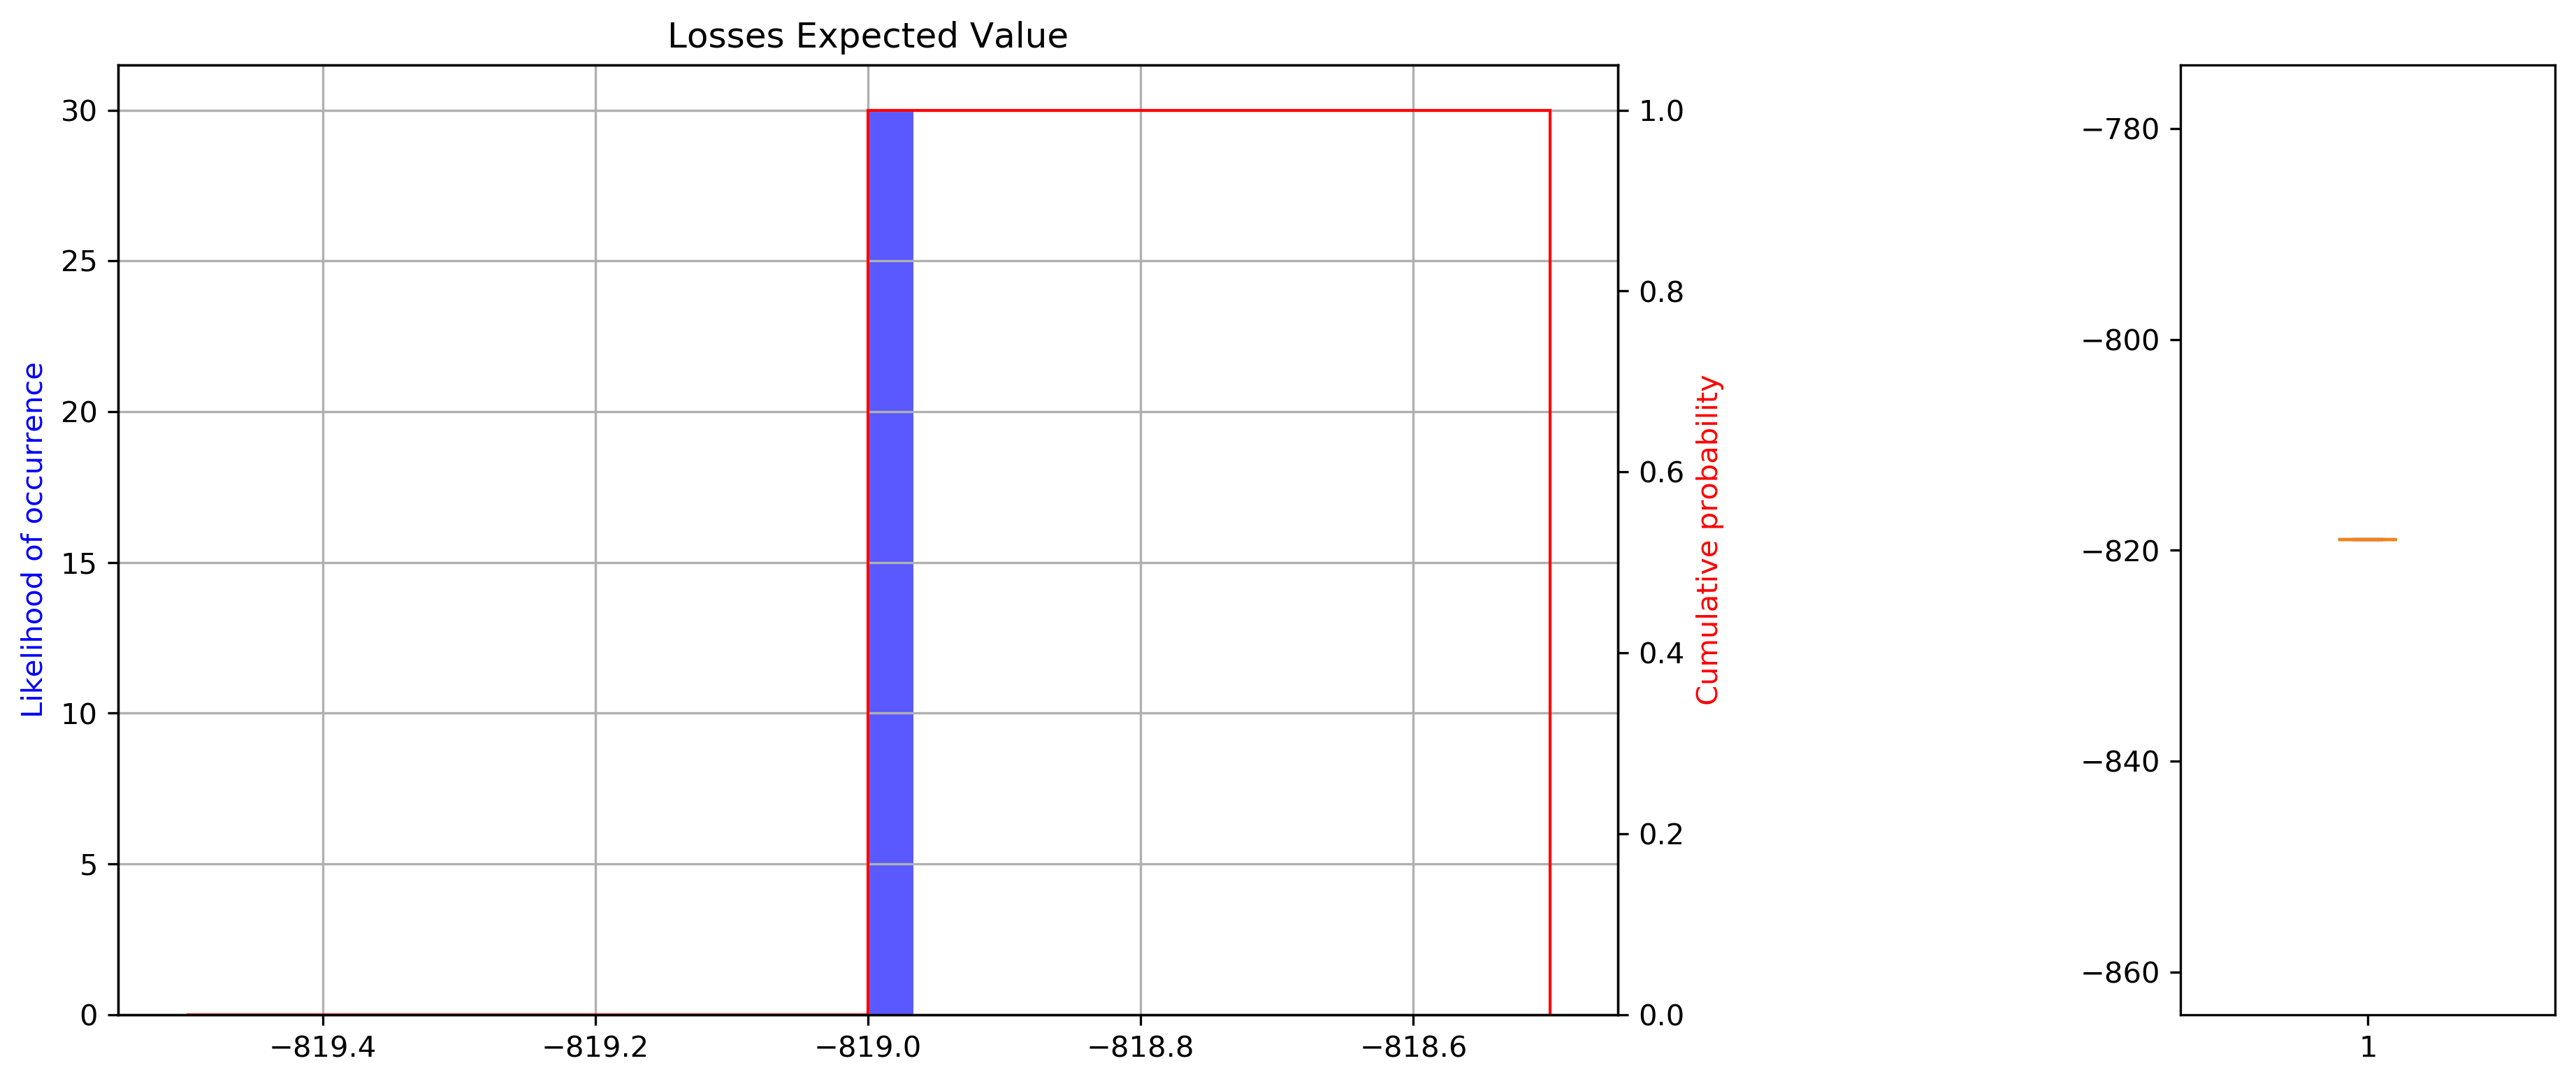

In [304]:
doubleHist(sol3, xlabel='Losses Expected Value')

*Maximizing the worst case scenario eliminates risk exposure, but reduces the profit opportunities. The average profit reduces from 4481.34 to 819*